In [ ]:

#upload csv file
print("upload your csv file-> heart_2022_no_nans.csv ")
from google.colab import files
uploaded = files.upload()

upload your csv file-> heart_2022_no_nans.csv 


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("heart_2022_no_nans.csv")
df = df.sample(frac=0.1, random_state=42)

binary_map = {"Yes": 1, "No": 0}
for col in ["HadHeartAttack", "HadAngina", "HadStroke"]:
    df[col] = df[col].map(binary_map)

df["CombinedHeartRisk"] = np.where(
    (df["HadHeartAttack"] == 1) |
    (df["HadAngina"] == 1) |
    (df["HadStroke"] == 1),
    1, 0
)

df_encoded = df.copy()
cat_cols = df_encoded.select_dtypes(include="object").columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

df_encoded.dropna(inplace=True)


Initial Shape: (24602, 41)
After Encoding: (24602, 41)

ZERO-VARIANCE COLUMNS FOUND:
[]

Before Shape: (24602, 41)
After Shape: (24602, 41)

After SMOTE: (34854, 39)
[LightGBM] [Info] Number of positive: 17427, number of negative: 17427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data points in the train set: 34854, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



========== HYBRID STACKING MODEL ==========

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4357
           1       0.82      0.82      0.82       564

    accuracy                           0.96      4921
   macro avg       0.90      0.90      0.90      4921
weighted avg       0.96      0.96      0.96      4921

ROC-AUC = 0.9485085140566172


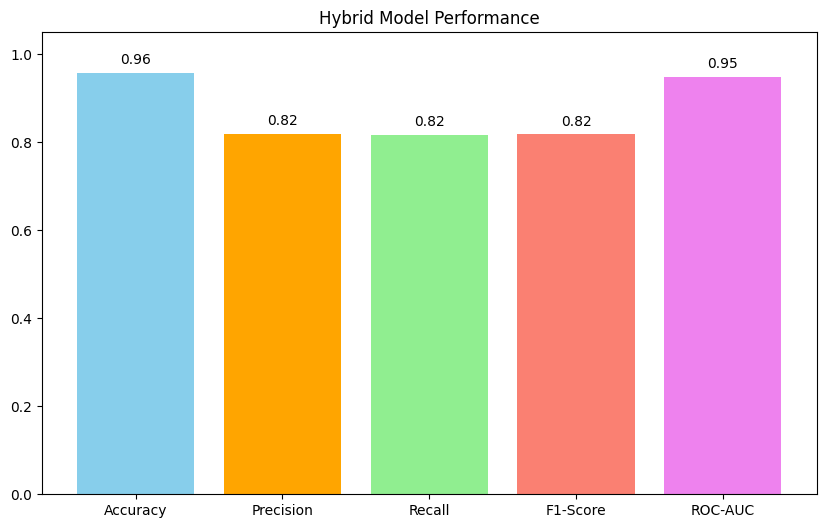

In [ ]:
# =============================================================
# 1) UPLOAD CSV


# =============================================================
# 2) LOAD + BASIC CLEANING
# =============================================================
import pandas as pd
import numpy as np

df = pd.read_csv("heart_2022_no_nans.csv")
df = df.sample(frac=0.1, random_state=42)

binary_map = {"Yes": 1, "No": 0}

for col in ["HadHeartAttack", "HadAngina", "HadStroke"]:
    df[col] = df[col].map(binary_map)

df["CombinedHeartRisk"] = np.where(
    (df["HadHeartAttack"] == 1) |
    (df["HadAngina"] == 1) |
    (df["HadStroke"] == 1),
    1, 0
)

print("Initial Shape:", df.shape)


# =============================================================
# 3) ENCODING
# =============================================================
df_encoded = df.copy()
cat_cols = df_encoded.select_dtypes(include="object").columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

df_encoded.dropna(inplace=True)

print("After Encoding:", df_encoded.shape)


# =============================================================
# 4) ZERO-VALUE & ZERO-VARIANCE FEATURE REMOVAL
# =============================================================
zero_value_cols = [col for col in df_encoded.columns if df_encoded[col].nunique() <= 1]

print("\nZERO-VARIANCE COLUMNS FOUND:")
print(zero_value_cols)

df_before = df_encoded.copy()
df_after = df_encoded.drop(columns=zero_value_cols)

print("\nBefore Shape:", df_before.shape)
print("After Shape:", df_after.shape)


# =============================================================
# 5) SPLIT + SMOTE
# =============================================================
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df_after.drop(columns=["CombinedHeartRisk", "HadHeartAttack"])
y = df_after["CombinedHeartRisk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:", X_train_res.shape)


# =============================================================
# 6) LEVEL-1 MODELS
# =============================================================
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier(n_estimators=200, random_state=42)
gb = GradientBoostingClassifier(random_state=42)
lr = LogisticRegression(max_iter=2000, random_state=42)

rf.fit(X_train_res, y_train_res)
gb.fit(X_train_res, y_train_res)
lr.fit(X_train_res, y_train_res)


# Level-1 Predictions
rf_train = rf.predict_proba(X_train_res)[:,1]
gb_train = gb.predict_proba(X_train_res)[:,1]
lr_train = lr.predict_proba(X_train_res)[:,1]

rf_test  = rf.predict_proba(X_test)[:,1]
gb_test  = gb.predict_proba(X_test)[:,1]
lr_test  = lr.predict_proba(X_test)[:,1]

# Meta Inputs
X_meta_train = np.column_stack([rf_train, gb_train, lr_train, X_train_res])
X_meta_test  = np.column_stack([rf_test, gb_test, lr_test, X_test])


# =============================================================
# 7) META MODEL (LightGBM)
# =============================================================
from lightgbm import LGBMClassifier

meta_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

meta_model.fit(X_meta_train, y_train_res)


# =============================================================
# 8) PERFORMANCE EVALUATION
# =============================================================
from sklearn.metrics import classification_report, roc_auc_score

y_pred = meta_model.predict(X_meta_test)
y_proba = meta_model.predict_proba(X_meta_test)[:,1]

print("\n========== HYBRID STACKING MODEL ==========\n")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC =", roc_auc)


# =============================================================
# 9) EXTRACT METRICS FOR VISUALIZATION
# =============================================================
report = classification_report(y_test, y_pred, output_dict=True)

accuracy  = report["accuracy"]
precision = report["1"]["precision"]
recall    = report["1"]["recall"]
f1        = report["1"]["f1-score"]

metrics_names  = ["Accuracy","Precision","Recall","F1-Score","ROC-AUC"]
metrics_values = [accuracy, precision, recall, f1, roc_auc]


# =============================================================
# 10) BAR CHART
# =============================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
colors = ["skyblue","orange","lightgreen","salmon","violet"]
bars = plt.bar(metrics_names, metrics_values, color=colors)
plt.ylim(0,1.05)
plt.title("Hybrid Model Performance")

for bar, val in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, val+0.02, f"{val:.2f}", ha="center")

plt.show()



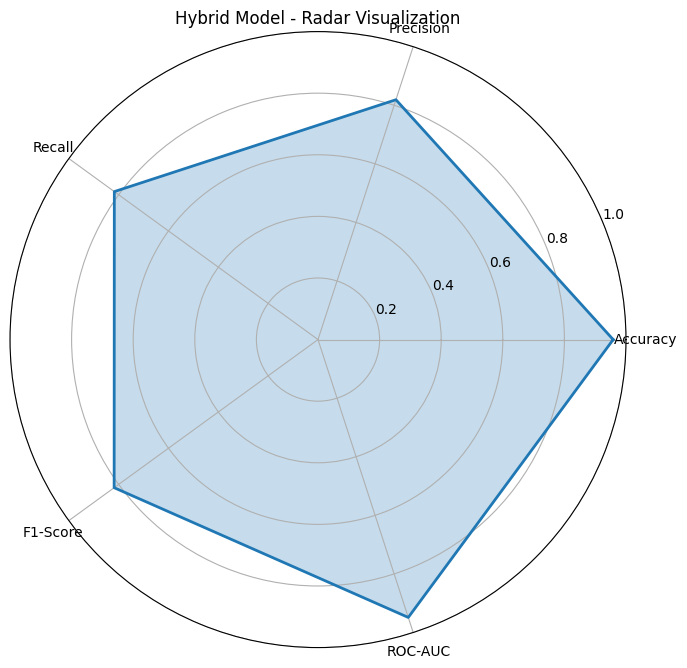

In [ ]:
# 11) RADAR PLOT
# =============================================================
angles = np.linspace(0, 2*np.pi, len(metrics_values), endpoint=False).tolist()
values = metrics_values + [metrics_values[0]]
angles += [angles[0]]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, polar=True)

ax.plot(angles, values, linewidth=2)
ax.fill(angles, values, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), metrics_names)
ax.set_ylim(0,1)
plt.title("Hybrid Model - Radar Visualization")
plt.Text("")
plt.show()

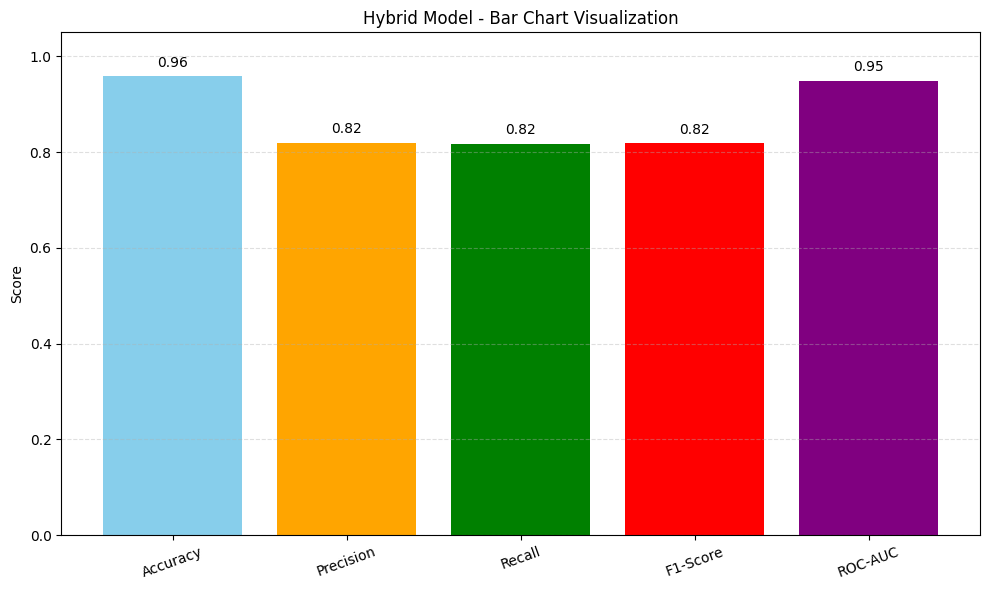

In [ ]:
# 11-B) BAR CHART for Radar Metrics
# =============================================================

plt.figure(figsize=(10,6))
bars = plt.bar(metrics_names, metrics_values, color=['skyblue','orange','green','red','purple'])

plt.title("Hybrid Model - Bar Chart Visualization")
plt.ylabel("Score")
plt.ylim(0,1.05)

# Add value labels above bars
for bar, val in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2,
             val + 0.02,
             f"{val:.2f}",
             ha='center', fontsize=10)

plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


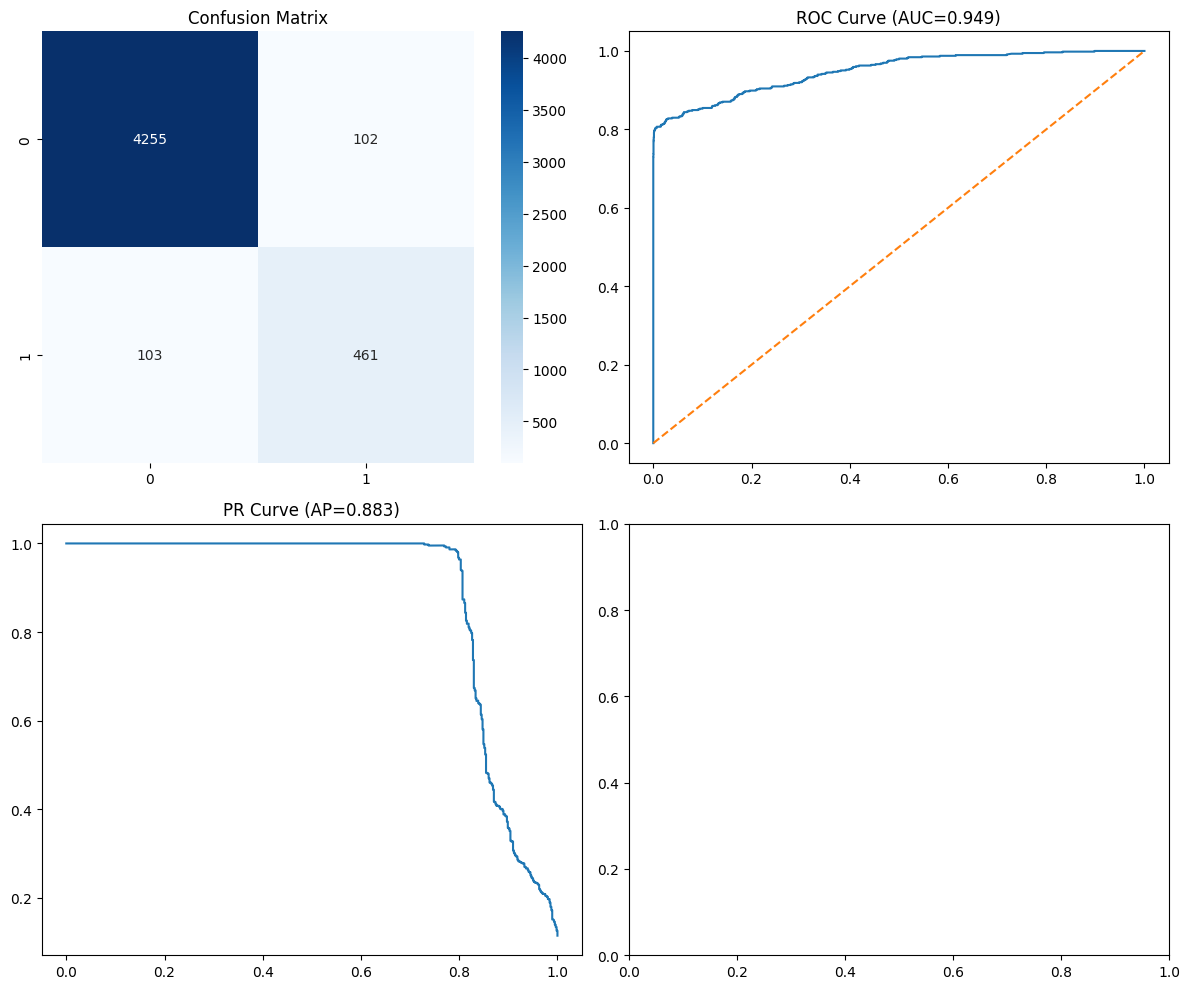

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


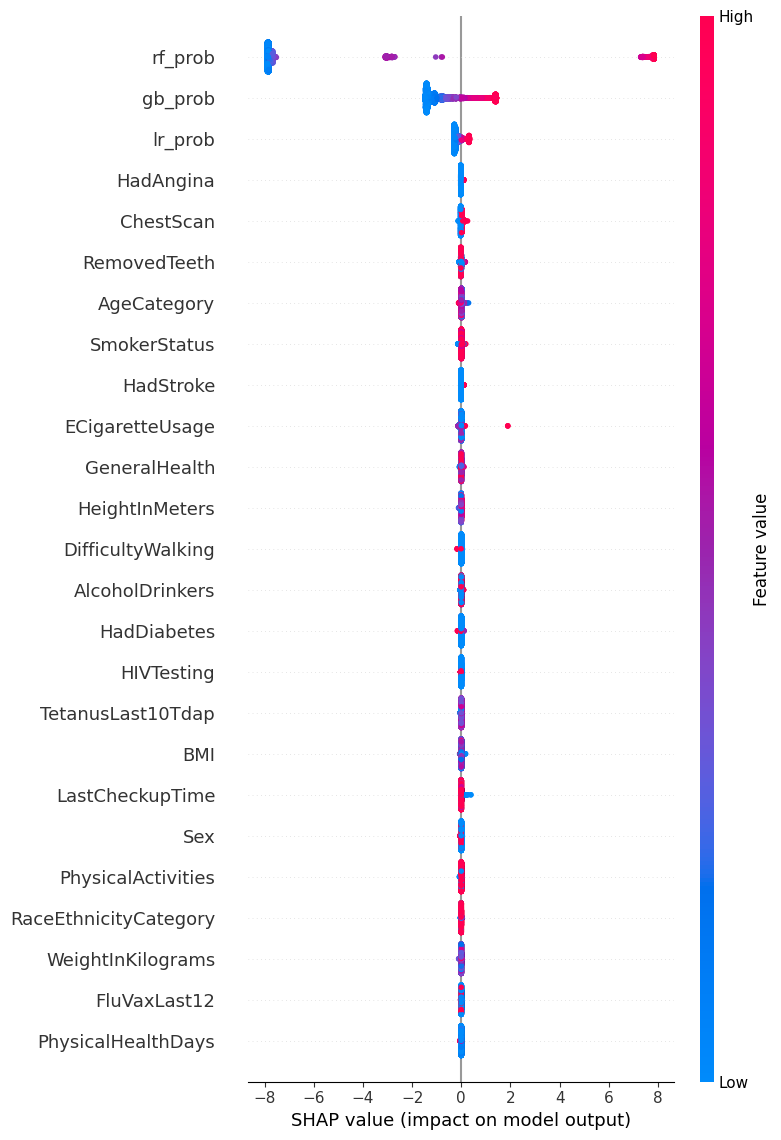

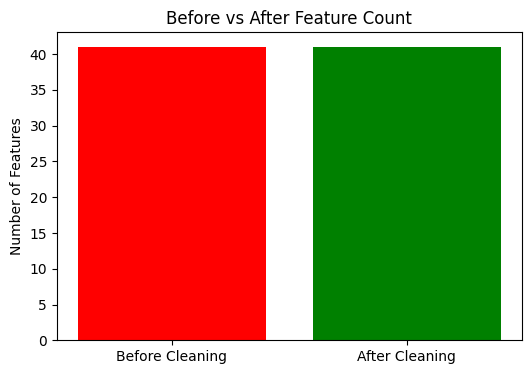

In [ ]:

# =============================================================



# =============================================================
# 12) CONFUSION MATRIX + ROC + PR CURVE
# =============================================================
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

fpr, tpr, _ = roc_curve(y_test, y_proba)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

fig, axs = plt.subplots(2,2, figsize=(12,10))

# Confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[0,0])
axs[0,0].set_title("Confusion Matrix")

# ROC
axs[0,1].plot(fpr, tpr)
axs[0,1].plot([0,1],[0,1],"--")
axs[0,1].set_title(f"ROC Curve (AUC={roc_auc:.3f})")

# PR
axs[1,0].plot(recall_curve, precision_curve)
axs[1,0].set_title(f"PR Curve (AP={ap:.3f})")

plt.tight_layout()
plt.show()


# =============================================================
# 13) SHAP SUMMARY
# =============================================================
import shap

meta_feature_names = ["rf_prob","gb_prob","lr_prob"] + list(X.columns)
X_shap = pd.DataFrame(X_meta_test, columns=meta_feature_names)

explainer = shap.TreeExplainer(meta_model)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap, max_display=25)


# =============================================================
# 14) BEFORE vs AFTER COMPARISON (VISUAL)
# =============================================================
before_cols = df_before.shape[1]
after_cols  = df_after.shape[1]

plt.figure(figsize=(6,4))
plt.bar(["Before Cleaning","After Cleaning"], [before_cols, after_cols], color=["red","green"])
plt.title("Before vs After Feature Count")
plt.ylabel("Number of Features")
plt.show()


In [ ]:
# =============================================================
# RUN HYBRID MODEL ON df_before (No zero-value removal)
# =============================================================

Xb = df_before.drop(columns=["CombinedHeartRisk", "HadHeartAttack"])
yb = df_before["CombinedHeartRisk"]

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    Xb, yb, test_size=0.2, stratify=yb, random_state=42
)

sm = SMOTE(random_state=42)
Xb_train_res, yb_train_res = sm.fit_resample(Xb_train, yb_train)

# Train same level-1 models
rf_b = RandomForestClassifier(n_estimators=200, random_state=42)
gb_b = GradientBoostingClassifier(random_state=42)
lr_b = LogisticRegression(max_iter=2000, random_state=42)

rf_b.fit(Xb_train_res, yb_train_res)
gb_b.fit(Xb_train_res, yb_train_res)
lr_b.fit(Xb_train_res, yb_train_res)

# L1 predictions
rf_b_train = rf_b.predict_proba(Xb_train_res)[:,1]
gb_b_train = gb_b.predict_proba(Xb_train_res)[:,1]
lr_b_train = lr_b.predict_proba(Xb_train_res)[:,1]

rf_b_test = rf_b.predict_proba(Xb_test)[:,1]
gb_b_test = gb_b.predict_proba(Xb_test)[:,1]
lr_b_test = lr_b.predict_proba(Xb_test)[:,1]

Xb_meta_train = np.column_stack([rf_b_train, gb_b_train, lr_b_train, Xb_train_res])
Xb_meta_test = np.column_stack([rf_b_test, gb_b_test, lr_b_test, Xb_test])

# Meta model before cleaning
meta_before = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

meta_before.fit(Xb_meta_train, yb_train_res)

yb_pred = meta_before.predict(Xb_meta_test)
yb_proba = meta_before.predict_proba(Xb_meta_test)[:,1]

roc_auc_before = roc_auc_score(yb_test, yb_proba)
report_before = classification_report(yb_test, yb_pred, output_dict=True)

accuracy_before  = report_before["accuracy"]
precision_before = report_before["1"]["precision"]
recall_before    = report_before["1"]["recall"]
f1_before        = report_before["1"]["f1-score"]


[LightGBM] [Info] Number of positive: 17427, number of negative: 17427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data points in the train set: 34854, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Zero-value columns removed: []
Before shape: (24602, 41)
After shape: (24602, 41)


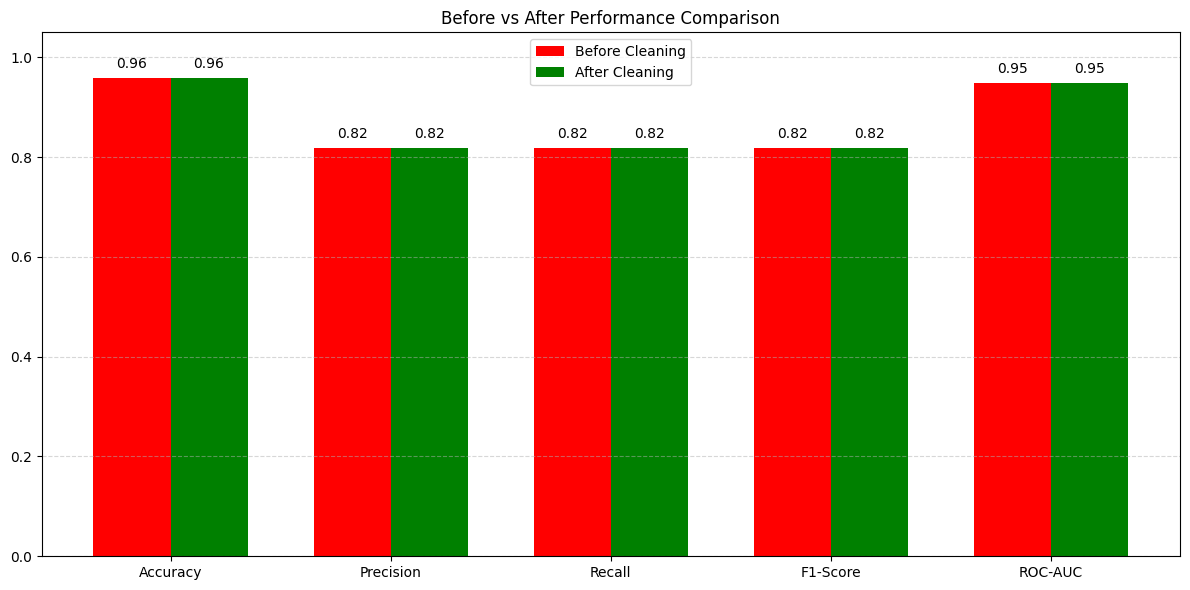

In [ ]:
# =============================================================
# BEFORE vs AFTER METRICS BAR CHART  (FINAL VISUALIZATION)
# =============================================================

metrics_names = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

metrics_before = [
    accuracy_before,
    precision_before,
    recall_before,
    f1_before,
    roc_auc_before
]

metrics_after = [
    accuracy,
    precision,
    recall,
    f1,
    roc_auc
]
print("Zero-value columns removed:", zero_value_cols)
print("Before shape:", df_before.shape)
print("After shape:", df_after.shape)

x = np.arange(len(metrics_names))
width = 0.35

plt.figure(figsize=(12,6))

# Before bars
plt.bar(x - width/2, metrics_before, width, label='Before Cleaning', color='red')

# After bars
plt.bar(x + width/2, metrics_after, width, label='After Cleaning', color='green')

plt.xticks(x, metrics_names)
plt.title("Before vs After Performance Comparison")
plt.ylim(0,1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Label values
for i, val in enumerate(metrics_before):
    plt.text(i - width/2, val + 0.02, f"{val:.2f}", ha='center')

for i, val in enumerate(metrics_after):
    plt.text(i + width/2, val + 0.02, f"{val:.2f}", ha='center')

plt.tight_layout()
plt.show()
